# Project: Wrangle and Analyze WeRateDogs twitter data

## *Yagmur Dalman*

In [2238]:
import pandas as pd
import numpy as np
import requests
import re
import os
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

## Gather Data

In [2239]:
# Read the csv file
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [2240]:
# Download the tsv file using the Requests library and the given URL
url =' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open('image-predictions.tsv', 'wb') as f:
        f.write(r.content)
df_image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##### Fetching Data from the Twitter API
Since it is a long process I put this code into a separate python file called: `fetch_twitter_data.py`

Set-up tweepy API with the required keys. Fetch each tweet one by one and write into a file called `tweet_json.txt`

In [2241]:

'''
# Query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of 
# JSON data in a file called tweet_json.txt file

consumer_key = 'X'
consumer_secret = 'X'
access_token = 'X'
access_secret = 'X'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

with open('tweet_json.txt', 'a', encoding='utf8') as f:
    for tweet_id in df_twitter_archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id)
            json.dump(tweet._json, f)
            f.write('\n')
        except:
            print("Error on tweet: " + str(tweet_id))
            continue

'''

'\n# Query the Twitter API for each tweet\'s JSON data using Python\'s Tweepy library and store each tweet\'s entire set of \n# JSON data in a file called tweet_json.txt file\n\nconsumer_key = \'X\'\nconsumer_secret = \'X\'\naccess_token = \'X\'\naccess_secret = \'X\'\n\nauth = tweepy.OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\napi = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)\n\nwith open(\'tweet_json.txt\', \'a\', encoding=\'utf8\') as f:\n    for tweet_id in df_twitter_archive[\'tweet_id\']:\n        try:\n            tweet = api.get_status(tweet_id)\n            json.dump(tweet._json, f)\n            f.write(\'\n\')\n        except:\n            print("Error on tweet: " + str(tweet_id))\n            continue\n\n'

In [2242]:
# Create a dataframe with tweet ID, retweet count, and favorite count
df_list = []
with open('tweet_json.txt') as file:
    for line in file:
        tweet = json.loads(line)
        
        df_list.append({
            'tweet_id': tweet['id'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count']
        })
df_tweet = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
       
df_tweet.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8315,38014
1,892177421306343426,6142,32641
2,891815181378084864,4067,24565
3,891689557279858688,8450,41365
4,891327558926688256,9157,39551


## Assess Data

In [2243]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [2244]:
df_twitter_archive[df_twitter_archive.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547188785154/photo/1,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [2245]:
df_twitter_archive[df_twitter_archive.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [2246]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [2247]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [2248]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [2249]:
df_twitter_archive.name

0       Phineas 
1       Tilly   
2       Archie  
3       Darla   
4       Franklin
5       None    
6       Jax     
7       None    
8       Zoey    
9       Cassie  
10      Koda    
11      Bruno   
12      None    
13      Ted     
14      Stuart  
15      Oliver  
16      Jim     
17      Zeke    
18      Ralphus 
19      Canela  
20      Gerald  
21      Jeffrey 
22      such    
23      Canela  
24      None    
25      None    
26      Maya    
27      Mingus  
28      Derek   
29      Roscoe  
         ...    
2326    quite   
2327    a       
2328    None    
2329    None    
2330    None    
2331    None    
2332    None    
2333    an      
2334    a       
2335    an      
2336    None    
2337    None    
2338    None    
2339    None    
2340    None    
2341    None    
2342    None    
2343    None    
2344    None    
2345    the     
2346    the     
2347    a       
2348    a       
2349    an      
2350    a       
2351    None    
2352    a       
2353    a     

In [2250]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [2251]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [2252]:
df_tweet

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8315,38014
1,892177421306343426,6142,32641
2,891815181378084864,4067,24565
3,891689557279858688,8450,41365
4,891327558926688256,9157,39551
5,891087950875897856,3046,19860
6,890971913173991426,2019,11614
7,890729181411237888,18445,64155
8,890609185150312448,4183,27288
9,890240255349198849,7215,31306


In [2253]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
tweet_id          2339 non-null int64
retweet_count     2339 non-null int64
favorite_count    2339 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


### Quality 
#### `df_twitter_archive` table
- 181 Retweets
- Missing data in expanded_urls (Tweets without images)
- Not all images are dog images
- The ratings aren't all correct
- Incorrect dog names (a, an, the, etc.)
- Missing values in dog names (represented as None)
- Erroneous datatype (tweet_id, timestamp)
- Hard to understand the source from source column
- Dog stage's type to categorical

#### `df_image_predictions` table
- Missing records (2075 instead of 2356, some of them are probably the retweets, replies or tweets with no images)
- Image predictions that are not dog breed
- Lowercase breed names in p1, p2, p3 and '_' is used instead of space.




### Tidiness
- Merge three data frames.
- Drop unneeded columns.
- Combine dog "stage" columns (i.e. doggo, floofer, pupper, and puppo) into one column.
- Combine rating_numerator and rating_denominator columns into one column.


## Clean Data

In [2254]:
# Create the copies of the dataframes which will be cleaned
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_tweet_clean = df_tweet.copy()

#### Remove Retweets

##### Define

Remove 181 columns which are retweets and detected by the columns: *retweeted_status_id*, *retweeted_status_user_id* and *retweeted_status_timestamp*. Remove retweets by keeping the null rows of *retweeted_status_id* column.

##### Code

In [2255]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.retweeted_status_id.isnull()]

##### Test

In [2256]:
 df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

#### Missing data in expanded_urls

##### Define

Remove the tweets without expanded_urls i.e images by keeping the non null data in the *expanded_urls* column.

##### Code

In [2257]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.expanded_urls.notnull()]

##### Test

In [2258]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
dtypes: float64(4), int64(3), object(1

Note: By cleaning the tweets without expanded_urls, we also drop some of the replies.

#### Merge three data frames

##### Define

Merge the `df_tweet_clean` and `df_image_predictions` tables to the `df_twitter_archive_clean` table, both joining on *tweet_id*.

##### Code

In [2259]:
# First, merge df_tweet_clean table to the df_twitter_archive_clean
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_tweet_clean, 
                                    on = ['tweet_id'], how = 'left')

In [2260]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2116
Data columns (total 19 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
retweet_count                 2114 non

In [2261]:
# Second, merge df_image_predictions table to the df_twitter_archive_clean
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_image_predictions, 
                                    on = ['tweet_id'], how = 'left')

##### Test

In [2262]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2116
Data columns (total 30 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
retweet_count                 2114 non

**After merging the data frames, keep the tweets with images.**

In [2263]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.jpg_url.notnull()]


In [2264]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2116
Data columns (total 30 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
retweet_count                 1991 non

**Drop the tweets with no retweet_count**

In [2265]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.retweet_count.notnull()]

In [2266]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2116
Data columns (total 30 columns):
tweet_id                      1991 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1991 non-null object
source                        1991 non-null object
text                          1991 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1991 non-null object
rating_numerator              1991 non-null int64
rating_denominator            1991 non-null int64
name                          1991 non-null object
doggo                         1991 non-null object
floofer                       1991 non-null object
pupper                        1991 non-null object
puppo                         1991 non-null object
retweet_count                 1991 non

#### Drop unneeded columns

##### Define

Drop the the columns related to the retweets and the replies: *retweeted_status_id*, *retweeted_status_user_id*, *retweeted_status_timestamp*, *in_reply_to_status_id*, *in_reply_to_user_id.*

##### Code

In [2267]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(['retweeted_status_id','retweeted_status_user_id',
                              'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)

##### Test

In [2268]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2116
Data columns (total 25 columns):
tweet_id              1991 non-null int64
timestamp             1991 non-null object
source                1991 non-null object
text                  1991 non-null object
expanded_urls         1991 non-null object
rating_numerator      1991 non-null int64
rating_denominator    1991 non-null int64
name                  1991 non-null object
doggo                 1991 non-null object
floofer               1991 non-null object
pupper                1991 non-null object
puppo                 1991 non-null object
retweet_count         1991 non-null float64
favorite_count        1991 non-null float64
jpg_url               1991 non-null object
img_num               1991 non-null float64
p1                    1991 non-null object
p1_conf               1991 non-null float64
p1_dog                1991 non-null object
p2                    1991 non-null object
p2_conf               1991 non-n

#### Combine dog "stage" columns (i.e. doggo, floofer, pupper, and puppo) into one column.


##### Define

Create a new column named *dog_stage*. Extract doggo, floofer, pupper and puppo from the *text* column using pandas' `str.extact method` and place them into the *dog_stage* column. Fill the null values with None.

##### Code

In [2269]:
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean['text'].str.extract('(doggo|floofer|pupper|puppo)',
                                                                             expand=True)
df_twitter_archive_clean = df_twitter_archive_clean.drop(['doggo','floofer','pupper','puppo'], axis=1)
df_twitter_archive_clean['dog_stage'].fillna('None', inplace=True)

##### Test

In [2270]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2116
Data columns (total 22 columns):
tweet_id              1991 non-null int64
timestamp             1991 non-null object
source                1991 non-null object
text                  1991 non-null object
expanded_urls         1991 non-null object
rating_numerator      1991 non-null int64
rating_denominator    1991 non-null int64
name                  1991 non-null object
retweet_count         1991 non-null float64
favorite_count        1991 non-null float64
jpg_url               1991 non-null object
img_num               1991 non-null float64
p1                    1991 non-null object
p1_conf               1991 non-null float64
p1_dog                1991 non-null object
p2                    1991 non-null object
p2_conf               1991 non-null float64
p2_dog                1991 non-null object
p3                    1991 non-null object
p3_conf               1991 non-null float64
p3_dog                1991 non

In [2271]:
df_twitter_archive_clean[['dog_stage']]

,dog_stage
0,None
1,None
2,None
3,None
4,None
5,None
6,None
7,None
8,None
9,doggo


In [2272]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,8315.0,38014.0,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,6142.0,32641.0,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,4067.0,24565.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,8450.0,41365.0,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,9157.0,39551.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None


#### Not all images are dog images


##### Define

Find the images that do not contain dogs by exploring the ratings and the text, then drop those data from the `df_twitter_archive_clean` data frame. 

##### Code

In [2273]:
# rating_numerator is usually greater than 10, 0 is an extreme value so tweets with numerator of 0 should be checked
df_twitter_archive_clean.query('rating_numerator == 0')[['text','expanded_urls']]

,text,expanded_urls
249,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1"
807,"PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",https://twitter.com/dog_rates/status/746906459439529985/photo/1


These two images with the 0 rating_numerator are not dogs' images and should be dropped.

In [2274]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(labels=[249,807],axis=0)

In [2275]:
# Test if the rows are dropped
df_twitter_archive_clean.query('rating_numerator == 0')[['text','expanded_urls']]

,text,expanded_urls


In case of getting an image of something else rather than dogs the following statements are written in the text: 'only rate dogs','only send in dogs','only send dogs', 'stop sending', 'without a dog','not pet', 'w/out a dog'

In [2276]:
no_dogs = 'only rate dogs|only send in dogs|only send dogs|stop sending|without a dog|not pet| w/out a dog'
df_twitter_archive_clean[df_twitter_archive_clean['text'].str.contains(no_dogs)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
24,887101392804085760,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp,https://twitter.com/dog_rates/status/887101392804085760/photo/1,12,10,None,5837.0,30002.0,...,Samoyed,0.733942,True,Eskimo_dog,0.035029,True,Staffordshire_bullterrier,0.029705,True,None
43,883117836046086144,2017-07-07 00:17:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Please only send dogs. We don't rate mechanics, no matter how h*ckin good. Thank you... 13/10 would sneak a pat https://t.co/Se5fZ9wp5E","https://twitter.com/dog_rates/status/883117836046086144/photo/1,https://twitter.com/dog_rates/status/883117836046086144/photo/1",13,10,None,6531.0,36470.0,...,golden_retriever,0.949562,True,Labrador_retriever,0.045948,True,kuvasz,0.002471,True,None
54,880872448815771648,2017-06-30 19:35:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ugh not again. We only rate dogs. Please don't send in well-dressed floppy-tongued street penguins. Dogs only please. Thank you... 12/10 https://t.co/WiAMbTkDPf,https://twitter.com/dog_rates/status/880872448815771648/photo/1,12,10,None,3741.0,20880.0,...,Pembroke,0.791416,True,Norwich_terrier,0.061393,True,Chihuahua,0.033726,True,None
79,875021211251597312,2017-06-14 16:04:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Guys please stop sending pictures without any dogs in th- oh never mind hello excuse me sir. 12/10 stealthy as h*ck https://t.co/brCQoqc8AW,"https://twitter.com/dog_rates/status/875021211251597312/photo/1,https://twitter.com/dog_rates/status/875021211251597312/photo/1",12,10,None,4646.0,25058.0,...,West_Highland_white_terrier,0.714319,True,Siberian_husky,0.091913,True,Great_Pyrenees,0.046038,True,None
82,874057562936811520,2017-06-12 00:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I can't believe this keeps happening. This, is a birb taking a bath. We only rate dogs. Please only send dogs. Thank you... 12/10 https://t.co/pwY9PQhtP2",https://twitter.com/dog_rates/status/874057562936811520/photo/1,12,10,None,3905.0,22303.0,...,flat-coated_retriever,0.832177,True,black-and-tan_coonhound,0.040437,True,Newfoundland,0.028228,True,None
97,870804317367881728,2017-06-03 00:48:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Real funny guys. Sending in a pic without a dog in it. Hilarious. We'll rate the rug tho because it's giving off a very good vibe. 11/10 https://t.co/GCD1JccCyi,https://twitter.com/dog_rates/status/870804317367881728/photo/1,11,10,None,6163.0,33253.0,...,home_theater,0.168290,False,sandbar,0.098040,False,television,0.079729,False,None
109,867900495410671616,2017-05-26 00:29:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Unbelievable. We only rate dogs. Please don't send in non-canines like the ""I"" from Pixar's opening credits. Thank you... 12/10 https://t.co/JMhDNv5wXZ",https://twitter.com/dog_rates/status/867900495410671616/photo/1,12,10,None,4181.0,24065.0,...,Labrador_retriever,0.522644,True,kuvasz,0.332461,True,dalmatian,0.032008,True,None
112,867051520902168576,2017-05-23 16:16:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Oh my this spooked me up. We only rate dogs, not happy ghosts. Please send dogs only. It's a very simple premise. Thank you... 13/10 https://t.co/M5Rz0R8SIQ",https://twitter.com/dog_rates/status/867051520902168576/photo/1

Remove those tweets from the data frame.

In [2277]:
df_twitter_archive_clean = df_twitter_archive_clean[~df_twitter_archive_clean['text'].str.contains(no_dogs)]


##### Test

In [2278]:
df_twitter_archive_clean[df_twitter_archive_clean['text'].str.contains(no_dogs)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


In [2279]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1913 entries, 0 to 2116
Data columns (total 22 columns):
tweet_id              1913 non-null int64
timestamp             1913 non-null object
source                1913 non-null object
text                  1913 non-null object
expanded_urls         1913 non-null object
rating_numerator      1913 non-null int64
rating_denominator    1913 non-null int64
name                  1913 non-null object
retweet_count         1913 non-null float64
favorite_count        1913 non-null float64
jpg_url               1913 non-null object
img_num               1913 non-null float64
p1                    1913 non-null object
p1_conf               1913 non-null float64
p1_dog                1913 non-null object
p2                    1913 non-null object
p2_conf               1913 non-null float64
p2_dog                1913 non-null object
p3                    1913 non-null object
p3_conf               1913 non-null float64
p3_dog                1913 non

#### Incorrect dog names (a, an, the, etc.) and missing values in dog names (represented as None)


##### Define

Names are probably extracted after the statements 'This is','Here is', 'hello to', 'Meet'. So that is why we have lots of words in the *name* column such that; a, an, the, etc. Notice that all of those are lowercase. Find the lowercase names in *name* cloumn and re-extract the names that come after the statements: 'name is' and 'named'. Replace the rest of the lowercase names with 'None'. Also, change the name 'O' with "O'Malley".

##### Code

In [2280]:
df_twitter_archive_clean[df_twitter_archive_clean['name'].str.len() == 1][['name', 'text']]

,name,text
51,a,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
497,a,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq
596,O,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC
795,a,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW
797,a,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R
838,a,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa
1126,a,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu
1136,a,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1146,a,This is a Butternut Cumberfloof. It's not windy they just look like that. 11/10 back at it again with the red socks https://t.co/hMjzhdUHaW
1153,a,This is a Wild Tuscan Poofwiggle. Careful not to startle. Rare tongue slip. One eye magical. 12/10 would def pet https://t.co/4EnShAQjv6


Change the name 'O' with "O'Malley".

In [2281]:
df_twitter_archive_clean['name'] = df_twitter_archive_clean['name'].str.replace('O', "O'Malley")

In [2282]:
df_twitter_archive_clean.query('name == "a"')['text'].count()

48

In [2283]:
# See the whole text
pd.set_option('display.max_colwidth',-1)

df_twitter_archive_clean.query('name == "a"')['text']

51      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
497     Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq                           
795     This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW               
797     Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R                 
838     This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa                 
1126    Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu                                         
1136    Here is 

Mis-extracted names are all lowercase.

In [2284]:
df_twitter_archive_clean.loc[df_twitter_archive_clean['name'].str.islower()][['name', 'text']]

,name,text
21,such,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba
51,a,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
292,one,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK"
497,a,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq
659,my,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB
722,one,This is one of the most inspirational stories I've ever come across. I have no words. 14/10 for both doggo and owner https://t.co/I5ld3eKD5k
785,his,That is Quizno. This is his beach. He does not tolerate human shenanigans on his beach. 10/10 reclaim ur land doggo https://t.co/vdr7DaRSa7
786,one,This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10 https://t.co/z5bAdtn9kd
795,a,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW
797,a,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R


Re-extract the names following the statements 'named' and 'name is'.

In [2285]:
df_changed_names = df_twitter_archive_clean[df_twitter_archive_clean['name'].str.islower()]
for text in df_changed_names.text:
    found = re.findall(r'(?:named|name is)\s(\w+)', text)
    mask = df_twitter_archive_clean['text'] == text
    if len(found) > 0:
        df_twitter_archive_clean.loc[mask, 'name'] = found[0]
    else:
        df_twitter_archive_clean.loc[mask, 'name'] = 'None'
    

In [2286]:
df_twitter_archive_clean.loc[df_twitter_archive_clean['name'].str.islower()]['name'].count()

0

In [2287]:
df_twitter_archive_clean.query('name == "None"')['name'].count()

545

Checked only the lowercase names, 'None' names should also be checked.

In [2288]:
df_None_names = df_twitter_archive_clean[df_twitter_archive_clean['name']== 'None']
for text in df_None_names.text:
    found = re.findall(r'(?:named|name is)\s(\w+)', text)
    mask = df_twitter_archive_clean['text'] == text
    if len(found) > 0:
        df_twitter_archive_clean.loc[mask, 'name'] = found[0]
    else:
        df_twitter_archive_clean.loc[mask, 'name'] = 'None'
    

##### Test

In [2289]:
df_twitter_archive_clean.loc[df_twitter_archive_clean['name'].str.islower()]['name'].count()

0

In [2290]:
df_twitter_archive_clean.query('name == "None"')['name'].count()

538

More names are extracted from 'None' names.

In [2291]:
df_twitter_archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,8315.0,38014.0,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,6142.0,32641.0,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,4067.0,24565.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,8450.0,41365.0,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,9157.0,39551.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,3046.0,19860.0,...,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,None
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,2019.0,11614.0,...,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,None
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,18445.0,64155.0,...,Pomeranian,0.566142,True,Eskim

#### The ratings aren't all correct

##### Define

The rating_denominator is generally 10 or the multiples of 10. Find the exceptions and look if they are correctly extracted. Re-extract the tweets that have decimal rating_numerator (5 is extracted instead of 13.5). Some tweets have multiple ratings because their images contain multiple dogs. Also, in some tweets there are puppies and that is why we have the rating of 60/50. 

##### Code

Look at the tweets with rating_numerator 1 because it is a very low rating.

In [2292]:
df_twitter_archive_clean.query('rating_numerator == 1')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1857,670783437142401025,2015-11-29 01:56:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO,https://twitter.com/dog_rates/status/670783437142401025/photo/1,1,10,None,406.0,831.0,...,lacewing,0.381955,False,sulphur_butterfly,0.106810,False,leafhopper,0.068347,False,None
2023,667549055577362432,2015-11-20 03:44:31 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx,https://twitter.com/dog_rates/status/667549055577362432/photo/1,1,10,None,2323.0,5841.0,...,electric_fan,0.984377,False,spotlight,0.007737,False,lampshade,0.001901,False,None
2096,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,None,64.0,144.0,...,Maltese_dog,0.857531,True,toy_poodle,0.063064,True,miniature_poodle,0.025581,True,None
2099,666104133288665088,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,6433.0,14081.0,...,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False,None


The rating in the line 2096 is incorrectly extracted and should be changed. The others are not dogs and should be dropped, I will drop them after making the necessary changes.

In [2293]:
# Find the tweet with decimal numerator
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator==5]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
41,883482846933004288,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,9726.0,45078.0,...,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,None
561,781661882474196992,2016-09-30 01:08:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,https://twitter.com/dog_rates/status/781661882474196992/photo/1,5,10,None,2959.0,11143.0,...,Pembroke,0.438087,True,golden_retriever,0.226954,True,collie,0.070652,True,None
1184,699691744225525762,2016-02-16 20:28:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dave. He's a tropical pup. Short lil legs (dachshund mix?) Excels underwater, but refuses to eat kibble 5/10 https://t.co/ZJnCxlIf62",https://twitter.com/dog_rates/status/699691744225525762/photo/1,5,10,Dave,4891.0,10735.0,...,hippopotamus,0.982269,False,sea_lion,0.006295,False,dugong,0.005768,False,None
1288,691483041324204033,2016-01-25 04:49:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,"https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1",5,10,None,601.0,2485.0,...,bloodhound,0.886232,True,black-and-tan_coonhound,0.077420,True,Gordon_setter,0.009826,True,None
1362,687102708889812993,2016-01-13 02:43:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Army of water dogs here. None of them know where they're going. Have no real purpose. Aggressive barks. 5/10 for all https://t.co/A88x73TwMN,https://twitter.com/dog_rates/status/687102708889812993/photo/1,5,10,None,1056.0,2452.0,...,fiddler_crab,0.992069,False,quail,0.002491,False,rock_crab,0.001513,False,None
1395,684959798585110529,2016-01-07 04:48:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jerry. He's a neat dog. No legs (tragic). Has more horns than a dog usually does. Bark is unique af. 5/10 https://t.co/85q7xlplsJ,https://twitter.com/dog_rates/status/684959798585110529/photo/1,5,10,Jerry,3342.0,7146.0,...,llama,0.379624,False,triceratops,0.162761,False,hog,0.084251,False,None
1400,684880619965411328,2016-01-06 23:33:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a basking dino pupper. Looks powerful. Occasionally shits eggs. Doesn't want the holidays to end. 5/10 https://t.co/DnNweb5eTO,https://twitter.com/dog_rates/status/684880619965411328/photo/1,5,10,None,874.0,2206.0,...,clog,0.081101,False,spindle,0.066957,False,agama,0.060884,False,pupper
1421,683849932751646720,2016-01-04 03:18:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jiminy. He's not the brightest dog. Needs to lay off the kibble. 5/10 still petable https://t.co/omln4LOy1x,https://twitter.com/dog_rates/status/683849932751646720/photo/1,5,10,Jiminy,1046.0,2747.0,...,hog,0.458855,False,Mexican_hairless,0.164906,True,wild

In [2294]:
# Look at the data whose rating_denominator is different than 10.
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator!=10].text

341     The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                                                      
405     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
702     Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                                           
857     After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ                             
908     Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                                                
953     Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a                                      

- Notice 24/7 is not a rating so this tweet should be dropped.
- 50/50 and 4/20 are not the correct ratings and will be changed later.
- Some of them include two ratings.
- Some of them include more than one dog.

In [2295]:
# Drop the tweet with the rating 24/7.
df_twitter_archive_clean = df_twitter_archive_clean.drop(labels=405,axis=0)

In [2296]:
# Check if it is dropped
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator==24]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


Re-extract the ratings by taking the rating that has a denominator of 10 or multiples of 10. Also extract the decimal numerators.

In [2297]:
# Extract the rating_numerator
numerator_new = df_twitter_archive_clean.text.str.extract(r'(\d+(?:\.\d+)?)\/\d+0', expand=False)

# Compare the old rating numerator and the new one (for debugging purposes).
old = list(df_twitter_archive_clean.rating_numerator)
text = list(df_twitter_archive_clean.text)
for index, rating in enumerate(numerator_new):
    rating_old = old[index]
    if str(rating) != str(rating_old):
        print(text[index])
        print("Old: " + str(rating_old) + " New: " + str(rating) + "\n")


This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
Old: 5 New: 13.5

This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
Old: 75 New: 9.75

This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
Old: 27 New: 11.27

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Old: 9 New: 14

This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
Old: 7 New: 10

Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
Old: 26 New: 11.26

This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwoo

In [2298]:
df_twitter_archive_clean['rating_numerator'] = numerator_new

In [2299]:
# Extract the rating_denominator
denominator_new = df_twitter_archive_clean.text.str.extract(r'\d+(?:\.\d)?\/(\d+0)', expand=False)

# Compare the old rating denominator and the new one (for debugging purposes).
old = list(df_twitter_archive_clean.rating_denominator)
text = list(df_twitter_archive_clean.text)
for index, rating in enumerate(denominator_new):
    denominator_old = old[index]
    if str(rating) != str(denominator_old):
        print(text[index])
        print("Old: " + str(denominator_old) + " New: " + str(rating) + "\n")


After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Old: 11 New: 10

This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
Old: 11 New: 10

This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Old: 2 New: 10



In [2300]:
df_twitter_archive_clean['rating_denominator'] = denominator_new

Change the rating 50/50 with the correct rating 11/10, and 4/20 with 13/10

In [2301]:
df_twitter_archive_clean.rating_numerator.at[990] = '11'
df_twitter_archive_clean.rating_denominator.at[990] = '10'
df_twitter_archive_clean.rating_numerator.at[953] = '13'
df_twitter_archive_clean.rating_denominator.at[953] = '10'
(df_twitter_archive_clean.rating_numerator.loc[990], df_twitter_archive_clean.rating_denominator.loc[990], 
df_twitter_archive_clean.rating_numerator.loc[953], df_twitter_archive_clean.rating_denominator.loc[953])


('11', '10', '13', '10')

In [2302]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1912 entries, 0 to 2116
Data columns (total 22 columns):
tweet_id              1912 non-null int64
timestamp             1912 non-null object
source                1912 non-null object
text                  1912 non-null object
expanded_urls         1912 non-null object
rating_numerator      1912 non-null object
rating_denominator    1912 non-null object
name                  1912 non-null object
retweet_count         1912 non-null float64
favorite_count        1912 non-null float64
jpg_url               1912 non-null object
img_num               1912 non-null float64
p1                    1912 non-null object
p1_conf               1912 non-null float64
p1_dog                1912 non-null object
p2                    1912 non-null object
p2_conf               1912 non-null float64
p2_dog                1912 non-null object
p3                    1912 non-null object
p3_conf               1912 non-null float64
p3_dog                1912 n

The data type of *rating_numerator* and *rating_denominator* columns is string, change it to float.

In [2303]:
df_twitter_archive_clean.rating_numerator = df_twitter_archive_clean.rating_numerator.astype(float)
df_twitter_archive_clean.rating_denominator = df_twitter_archive_clean.rating_denominator.astype(float)


Now, drop the lines in which the rating_numerator is 1.

In [2304]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator != 1.0]


In [2305]:
# Check if they are dropped
df_twitter_archive_clean.query('rating_numerator == 1.0')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


##### Test

In [2306]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
341,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84.0,70.0,None,3511.0,12955.0,...,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True,None
702,758467244762497024,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165.0,150.0,None,2406.0,5083.0,...,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True,None
908,731156023742988288,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204.0,170.0,None,1351.0,4003.0,...,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False,doggo
1016,713900603437621249,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99.0,90.0,None,785.0,2956.0,...,golden_retriever,0.371816,True,cocker_spaniel,0.177413,True,Irish_setter,0.092725,True,pupper
1041,710658690886586372,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80.0,80.0,None,599.0,2406.0,...,soft-coated_wheaten_terrier,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,0.015943,True,pupper
1061,709198395643068416,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45.0,50.0,None,678.0,2517.0,...,borzoi,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,0.083184,True,None
1136,704054845121142784,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60.0,50.0,None,967.0,3052.0,...,Great_Pyrenees,0.667939,True,kuvasz,0.228764,True,golden_retriever,0.043885,True,pupper
1218,697463031882764288,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,https://twitter.com/dog_rates/status/697463031882764288/photo/1,44.0,40.0,None,1469.0,3567.0,...,Labrador_retriever,0.999885,True,golden_retriever,0.000098,True,pug,0.000008,True,None
1410,684225744407494656,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us

In [2307]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909 entries, 0 to 2116
Data columns (total 22 columns):
tweet_id              1909 non-null int64
timestamp             1909 non-null object
source                1909 non-null object
text                  1909 non-null object
expanded_urls         1909 non-null object
rating_numerator      1909 non-null float64
rating_denominator    1909 non-null float64
name                  1909 non-null object
retweet_count         1909 non-null float64
favorite_count        1909 non-null float64
jpg_url               1909 non-null object
img_num               1909 non-null float64
p1                    1909 non-null object
p1_conf               1909 non-null float64
p1_dog                1909 non-null object
p2                    1909 non-null object
p2_conf               1909 non-null float64
p2_dog                1909 non-null object
p3                    1909 non-null object
p3_conf               1909 non-null float64
p3_dog                1909

#### Combine rating_numerator and rating_denominator columns into one column

##### Define

Create a *rating* column by dividing rating_numerator values by rating_denominator values for an easier data analysis.

##### Code

In [2308]:
df_twitter_archive_clean['rating'] = df_twitter_archive_clean.rating_numerator / df_twitter_archive_clean.rating_denominator


##### Test

In [2309]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909 entries, 0 to 2116
Data columns (total 23 columns):
tweet_id              1909 non-null int64
timestamp             1909 non-null object
source                1909 non-null object
text                  1909 non-null object
expanded_urls         1909 non-null object
rating_numerator      1909 non-null float64
rating_denominator    1909 non-null float64
name                  1909 non-null object
retweet_count         1909 non-null float64
favorite_count        1909 non-null float64
jpg_url               1909 non-null object
img_num               1909 non-null float64
p1                    1909 non-null object
p1_conf               1909 non-null float64
p1_dog                1909 non-null object
p2                    1909 non-null object
p2_conf               1909 non-null float64
p2_dog                1909 non-null object
p3                    1909 non-null object
p3_conf               1909 non-null float64
p3_dog                1909

In [2310]:
df_twitter_archive_clean.rating.value_counts()

1.200      439
1.000      406
1.100      384
1.300      258
0.900      139
0.800      92 
0.700      48 
1.400      35 
0.600      32 
0.500      31 
0.300      17 
0.400      13 
0.200      9  
1.350      1  
1.127      1  
1.126      1  
177.600    1  
0.975      1  
42.000     1  
Name: rating, dtype: int64

Notice the outliers: 42 and 177.6

In [2311]:
df_twitter_archive_clean.query('rating == 42.00')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
1840,670842764863651840,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420.0,10.0,None,8966.0,24949.0,...,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False,None,42.0


This is Snoop Dogg, needs to be dropped.

In [2312]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(labels=1840,axis=0)

In [2313]:
df_twitter_archive_clean.query('rating == 177.600')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
772,749981277374128128,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776.0,10.0,Atticus,2633.0,5377.0,...,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,None,177.6


This is a dog rating but it is a very high number and in the data analysis it might be diffucult to work with such a high number. So I will change this rating to 1.5. It will still be the highest rating.

In [2314]:
df_twitter_archive_clean.rating.at[772] = 1.5

In [2315]:
df_twitter_archive_clean.query('rating == 1.5')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
772,749981277374128128,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776.0,10.0,Atticus,2633.0,5377.0,...,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,None,1.5


#### Dog stage's type to categorical


##### Define

Convert *dog_stage* to categorical data type.

##### Code

In [2316]:
# To category
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.astype('category')


##### Test

In [2317]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 0 to 2116
Data columns (total 23 columns):
tweet_id              1908 non-null int64
timestamp             1908 non-null object
source                1908 non-null object
text                  1908 non-null object
expanded_urls         1908 non-null object
rating_numerator      1908 non-null float64
rating_denominator    1908 non-null float64
name                  1908 non-null object
retweet_count         1908 non-null float64
favorite_count        1908 non-null float64
jpg_url               1908 non-null object
img_num               1908 non-null float64
p1                    1908 non-null object
p1_conf               1908 non-null float64
p1_dog                1908 non-null object
p2                    1908 non-null object
p2_conf               1908 non-null float64
p2_dog                1908 non-null object
p3                    1908 non-null object
p3_conf               1908 non-null float64
p3_dog                1908

#### Erroneous datatype (timestamp, tweet_id)

##### Define

Convert timestamp datetime data type and tweet_id to string data type.


##### Code

In [2318]:
# To datetime
df_twitter_archive_clean.timestamp = pd.to_datetime(df_twitter_archive_clean.timestamp)

# To string 
df_twitter_archive_clean.tweet_id = df_twitter_archive_clean.tweet_id.astype(str)


In [2319]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 0 to 2116
Data columns (total 23 columns):
tweet_id              1908 non-null object
timestamp             1908 non-null datetime64[ns]
source                1908 non-null object
text                  1908 non-null object
expanded_urls         1908 non-null object
rating_numerator      1908 non-null float64
rating_denominator    1908 non-null float64
name                  1908 non-null object
retweet_count         1908 non-null float64
favorite_count        1908 non-null float64
jpg_url               1908 non-null object
img_num               1908 non-null float64
p1                    1908 non-null object
p1_conf               1908 non-null float64
p1_dog                1908 non-null object
p2                    1908 non-null object
p2_conf               1908 non-null float64
p2_dog                1908 non-null object
p3                    1908 non-null object
p3_conf               1908 non-null float64
p3_dog           

In [2320]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8315.0,38014.0,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None,1.3
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6142.0,32641.0,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None,1.3
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4067.0,24565.0,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None,1.2
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8450.0,41365.0,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None,1.3
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9157.0,39551.0,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None,1.2


#### Hard to understand the source from source column


##### Define

Make the source readable and clear in the *source* column by re-extracting the source with regex.

##### Code

The source is given between the characters ">" and "<".

In [2321]:
df_twitter_archive_clean.source = df_twitter_archive_clean.source.apply(lambda x: re.findall(r'>(.*)<',x)[0])

##### Test

In [2322]:
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone    1871
Twitter Web Client    27  
TweetDeck             10  
Name: source, dtype: int64

In [2323]:
df_twitter_archive_clean[['source']]

,source
0,Twitter for iPhone
1,Twitter for iPhone
2,Twitter for iPhone
3,Twitter for iPhone
4,Twitter for iPhone
5,Twitter for iPhone
6,Twitter for iPhone
7,Twitter for iPhone
8,Twitter for iPhone
9,Twitter for iPhone


#### Lowercase breed names in p1, p2, p3 and '_'  is used instead of space.

##### Define

Replace the character '_' with space by using str.extract method and capitalize the first letters.

##### Code

In [2324]:
# Replace the character '_' with space
for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].str.replace('_',' ')

In [2325]:
df_twitter_archive_clean[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,orange,bagel,banana
1,Chihuahua,Pekinese,papillon
2,Chihuahua,malamute,kelpie
3,paper towel,Labrador retriever,spatula
4,basset,English springer,German short-haired pointer


Capitalize the first letters.

In [2326]:
for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].str.capitalize()

In [2327]:
def capitalize_words(breed_name):
    words = breed_name.split(' ')
    words = [word.capitalize() for word in words]
    return ' '.join(words)

for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].apply(capitalize_words)

##### Test

In [2328]:
df_twitter_archive_clean[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,Orange,Bagel,Banana
1,Chihuahua,Pekinese,Papillon
2,Chihuahua,Malamute,Kelpie
3,Paper Towel,Labrador Retriever,Spatula
4,Basset,English Springer,German Short-haired Pointer


#### Find the best dog breed prediction from p1, p2, p3 columns.

##### Define

Define a function to extract the best prediction from three prediction columns depending on their confidence levels. Then create columns for best breed prediction and its confidence level.

##### Code

In [2329]:
breed = []
confidence = []

# Define a function to find the best dog breed prediction.
def breed_conf(row):
    if row['p1_dog']==True:
        breed.append(row['p1'])
        confidence.append(row['p1_conf'])
    elif row['p2_dog']==True:
        breed.append(row['p2'])
        confidence.append(row['p2_conf'])
    elif row['p3_dog']==True:
        breed.append(row['p3'])
        confidence.append(row['p3_conf'])
    else:
        breed.append('None')
        confidence.append(0)

In [2330]:
# Apply the function to the df_twitter_archive_clean data frame.
df_twitter_archive_clean.apply(breed_conf, axis=1)

# Create columns for breed and confidence
df_twitter_archive_clean['breed'] = breed
df_twitter_archive_clean['confidence'] = confidence


##### Test

In [2331]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 0 to 2116
Data columns (total 25 columns):
tweet_id              1908 non-null object
timestamp             1908 non-null datetime64[ns]
source                1908 non-null object
text                  1908 non-null object
expanded_urls         1908 non-null object
rating_numerator      1908 non-null float64
rating_denominator    1908 non-null float64
name                  1908 non-null object
retweet_count         1908 non-null float64
favorite_count        1908 non-null float64
jpg_url               1908 non-null object
img_num               1908 non-null float64
p1                    1908 non-null object
p1_conf               1908 non-null float64
p1_dog                1908 non-null object
p2                    1908 non-null object
p2_conf               1908 non-null float64
p2_dog                1908 non-null object
p3                    1908 non-null object
p3_conf               1908 non-null float64
p3_dog           

In [2332]:
df_twitter_archive_clean[['breed','confidence']].head()

,breed,confidence
0,None,0.000000
1,Chihuahua,0.323581
2,Chihuahua,0.716012
3,Labrador Retriever,0.168086
4,Basset,0.555712


In [2333]:
df_twitter_archive_clean['breed'].value_counts()

None                           289
Golden Retriever               153
Labrador Retriever             102
Pembroke                       92 
Chihuahua                      90 
Pug                            59 
Toy Poodle                     51 
Chow                           44 
Pomeranian                     42 
Samoyed                        38 
Malamute                       32 
Chesapeake Bay Retriever       29 
Cocker Spaniel                 29 
French Bulldog                 28 
Miniature Pinscher             24 
Eskimo Dog                     22 
Staffordshire Bullterrier      21 
Beagle                         20 
German Shepherd                20 
Shih-tzu                       20 
Siberian Husky                 20 
Maltese Dog                    19 
Shetland Sheepdog              19 
Cardigan                       19 
Rottweiler                     19 
Kuvasz                         18 
Lakeland Terrier               18 
Basset                         17 
Italian Greyhound   

## Store Data

In [2334]:
#Save the gathered, assessed, and cleaned master dataset to a CSV file.
df_twitter_archive_clean.to_csv('twitter_archive_master.csv')

## Analyze Data

In [2335]:
df = pd.read_csv('twitter_archive_master.csv')
df.head()

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating,breed,confidence
0,0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8315.0,...,Bagel,0.085851,False,Banana,0.076110,False,None,1.3,None,0.000000
1,1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6142.0,...,Pekinese,0.090647,True,Papillon,0.068957,True,None,1.3,Chihuahua,0.323581
2,2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4067.0,...,Malamute,0.078253,True,Kelpie,0.031379,True,None,1.2,Chihuahua,0.716012
3,3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8450.0,...,Labrador Retriever,0.168086,True,Spatula,0.040836,False,None,1.3,Labrador Retriever,0.168086
4,4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9157.0,...,English Springer,0.225770,True,German Short-haired Pointer,0.175219,True,None,1.2,Basset,0.555712


In [2336]:
# Drop Unnamed: 0 column
df = df.drop(['Unnamed: 0'], axis=1)

In [2337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 25 columns):
tweet_id              1908 non-null int64
timestamp             1908 non-null object
source                1908 non-null object
text                  1908 non-null object
expanded_urls         1908 non-null object
rating_numerator      1908 non-null float64
rating_denominator    1908 non-null float64
name                  1908 non-null object
retweet_count         1908 non-null float64
favorite_count        1908 non-null float64
jpg_url               1908 non-null object
img_num               1908 non-null float64
p1                    1908 non-null object
p1_conf               1908 non-null float64
p1_dog                1908 non-null bool
p2                    1908 non-null object
p2_conf               1908 non-null float64
p2_dog                1908 non-null bool
p3                    1908 non-null object
p3_conf               1908 non-null float64
p3_dog                1908 non

In [2338]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating,breed,confidence
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8315.0,38014.0,...,Bagel,0.085851,False,Banana,0.076110,False,None,1.3,None,0.000000
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6142.0,32641.0,...,Pekinese,0.090647,True,Papillon,0.068957,True,None,1.3,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4067.0,24565.0,...,Malamute,0.078253,True,Kelpie,0.031379,True,None,1.2,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8450.0,41365.0,...,Labrador Retriever,0.168086,True,Spatula,0.040836,False,None,1.3,Labrador Retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9157.0,39551.0,...,English Springer,0.225770,True,German Short-haired Pointer,0.175219,True,None,1.2,Basset,0.555712


In [2339]:
# Descriptive analysis
df[['retweet_count','favorite_count','rating', 'confidence']].describe()

,retweet_count,favorite_count,rating,confidence
count,1908.000000,1908.000000,1908.000000,1908.000000
mean,2591.144130,8489.412998,1.061204,0.466313
std,4703.502207,12634.236572,0.210510,0.339239
min,12.000000,78.000000,0.200000,0.000000
25%,577.750000,1773.750000,1.000000,0.145375
50%,1245.000000,3777.500000,1.100000,0.457514
75%,2949.500000,10608.250000,1.200000,0.778514
max,83626.000000,164232.000000,1.500000,0.999956


In [2340]:
# Find the dog with the highest rating.
df.loc[df['rating'].idxmax()]

tweet_id              749981277374128128                                                            
timestamp             2016-07-04 15:00:45                                                           
source                TweetDeck                                                                     
text                  This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
expanded_urls         https://twitter.com/dog_rates/status/749981277374128128/photo/1               
rating_numerator      1776                                                                          
rating_denominator    10                                                                            
name                  Atticus                                                                       
retweet_count         2633                                                                          
favorite_count        5377                                                                 

Atticus has the highest rating 1776/10 (177.6). Observe that its retweet count is very close to the mean retweet count and its number of likes is much more lower than the mean favorite_count which is 8489.4. Atticus wears some clothes with the US flag so it explains why this rating is so high.

In [2341]:
# The most liked dog 
df.iloc[df['favorite_count'].idxmax()]

tweet_id              744234799360020481                                                                                                 
timestamp             2016-06-18 18:26:18                                                                                                
source                Twitter for iPhone                                                                                                 
text                  Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
expanded_urls         https://twitter.com/dog_rates/status/744234799360020481/video/1                                                    
rating_numerator      13                                                                                                                 
rating_denominator    10                                                                                                                 
name                  None        

This doggo without a name has the highest number of likes which and it is a Labrador Retriever. It has a cute video. 

In [2342]:
# Set the style
sns.set(style="darkgrid")

Text(0,0.5,'Count')

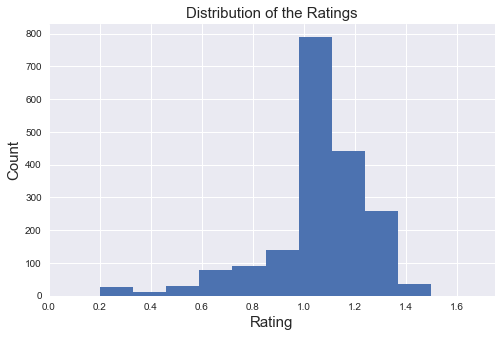

In [2343]:
df.rating.plot(kind='hist', xlim=[0,1.75], figsize=(8,5))
plt.title('Distribution of the Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)


The dog ratings are more frequent between 1 and 1.3.

Text(0,0.5,'Count')

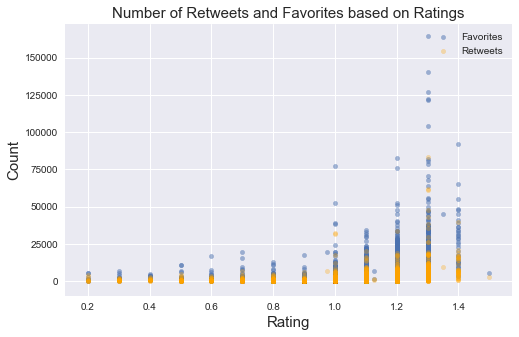

In [2344]:
ax = df.plot.scatter(x='rating', y='favorite_count', alpha=0.5, label='Favorites');
df.plot.scatter(x='rating', y='retweet_count', color='Orange', alpha=0.3, label='Retweets', ax=ax, figsize=(8,5));
plt.title('Number of Retweets and Favorites based on Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)


Text(0,0.5,'Count')

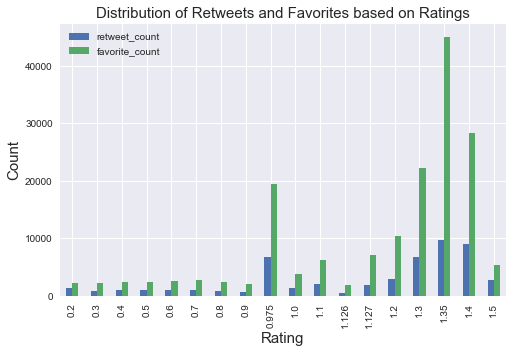

In [2345]:
df.groupby('rating')['retweet_count','favorite_count'].mean().plot(kind='bar', figsize=(8,5))
plt.title('Distribution of Retweets and Favorites based on Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)

It seems like there is a positive correlation between retweet counts and favorite counts based on ratings.

In [2346]:
df[['rating','retweet_count','favorite_count']].corr(method = 'pearson')


,rating,retweet_count,favorite_count
rating,1.000000,0.306295,0.406224
retweet_count,0.306295,1.000000,0.930268
favorite_count,0.406224,0.930268,1.000000


Pearson correlation coefficients shows that there is indeed a positive correlation between retweet counts and favorite counts. Surprisingly there is no correlation between ratings and retweet counts, as well as ratings and   favorite counts. One possible reason is that those ratings are given by only one account holder WeRateDogs and they are quite subjective. It is normal other people to like or retweet the tweets independent from their ratings but considering the pictures. Another reason might be the harmony between the picture and the tweet, if it is considered funny by the followers it might get higher number of likes and retweets even if it has a low rating. 




In [2347]:
df.breed.value_counts()[:25]

None                         289
Golden Retriever             153
Labrador Retriever           102
Pembroke                     92 
Chihuahua                    90 
Pug                          59 
Toy Poodle                   51 
Chow                         44 
Pomeranian                   42 
Samoyed                      38 
Malamute                     32 
Chesapeake Bay Retriever     29 
Cocker Spaniel               29 
French Bulldog               28 
Miniature Pinscher           24 
Eskimo Dog                   22 
Staffordshire Bullterrier    21 
Beagle                       20 
German Shepherd              20 
Shih-tzu                     20 
Siberian Husky               20 
Maltese Dog                  19 
Shetland Sheepdog            19 
Cardigan                     19 
Rottweiler                   19 
Name: breed, dtype: int64

Take the dog breeds which are tweeted more than 20 and exclude 'None'.

Text(0.5,0,'Breed')

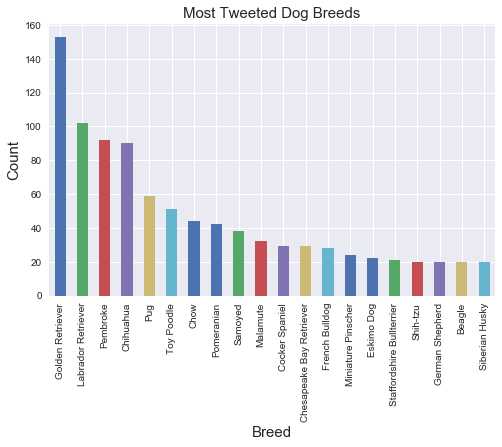

In [2348]:
hot_breeds=df.groupby('breed').filter(lambda x: 200 > len(x) > 19)
hot_breeds['breed'].value_counts().plot(kind = 'bar', figsize=(8,5))
plt.title('Most Tweeted Dog Breeds', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Breed', fontsize=15)

Most tweeted dog breeds in order: Golden Retriever, Labrador Retriever, Pembroke, Chihuahua, Pug

Text(0,0.5,'Rating')

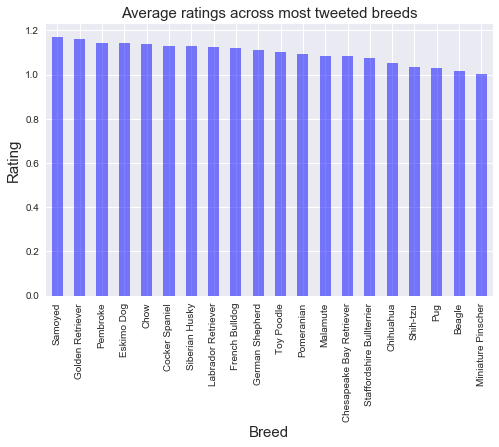

In [2349]:
hot_breeds.groupby('breed')['rating'].mean().sort_values(ascending=False).plot(kind ='bar', color = 'Blue', alpha=0.5,figsize=(8,5))
plt.title('Average ratings across most tweeted breeds', fontsize=15)
plt.xlabel('Breed', fontsize=15)
plt.ylabel('Rating', fontsize=15)


Most tweeted dog breeds with the highest rating in order: Samoyed, Golden Retriever, Pembroke, Eskimo Dog, Chow

Text(0,0.5,'Average favorite counts')

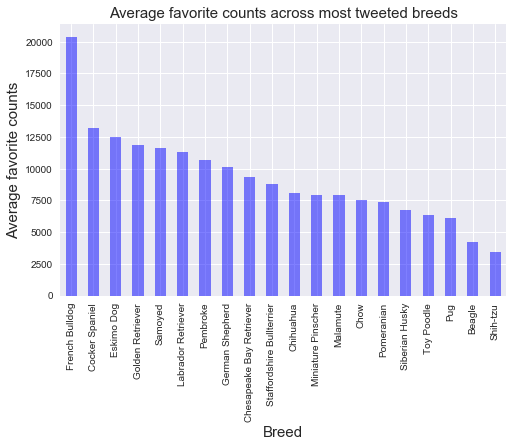

In [2350]:
hot_breeds.groupby('breed')['favorite_count'].mean().sort_values(ascending=False).plot(kind ='bar', color = 'Blue', alpha=0.5, figsize=(8,5))
plt.title('Average favorite counts across most tweeted breeds', fontsize=15)
plt.xlabel('Breed', fontsize=15)
plt.ylabel('Average favorite counts', fontsize=15)


Most tweeted dog breeds with the highest number of likes: French Bulldog, Cocker Spaniel, Eskimo Dog, Golden Retriever, Samoyed.

Most liked breeds differ from the breeds with highest ratings.

In [2351]:
df.dog_stage.value_counts()

None       1584
pupper     223 
doggo      70  
puppo      28  
floofer    3   
Name: dog_stage, dtype: int64

Text(0.5,0,'Dog Stage')

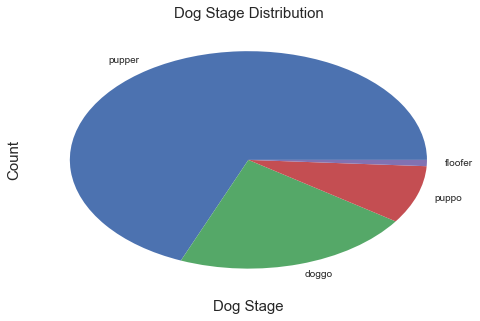

In [2352]:
dog_stages=df.groupby('dog_stage').filter(lambda x: len(x) < 250)
dog_stages['dog_stage'].value_counts().plot(kind = 'pie', figsize=(8,5))
plt.title('Dog Stage Distribution', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Dog Stage', fontsize=15)

Most of the dogs are pupper. There are only 3 floofer. I belive this number is a result of mis-extraction.

Text(0,0.5,'Count')

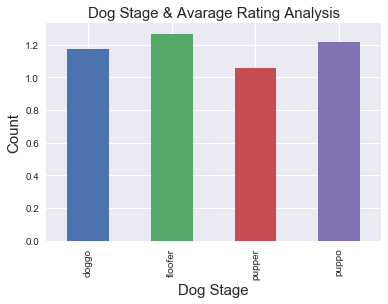

In [2353]:
dog_stages.groupby('dog_stage')['rating'].mean().plot(kind='bar')
plt.title('Dog Stage & Avarage Rating Analysis', fontsize=15)
plt.xlabel('Dog Stage', fontsize=15)
plt.ylabel('Count', fontsize=15)

Text(0,0.5,'Count')

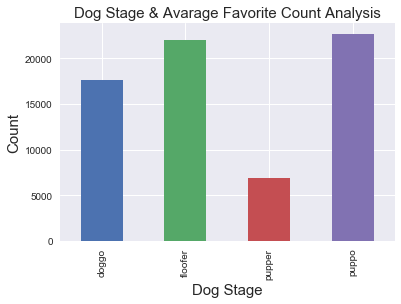

In [2354]:
dog_stages.groupby('dog_stage')['favorite_count'].mean().plot(kind='bar')
plt.title('Dog Stage & Avarage Favorite Count Analysis', fontsize=15)
plt.xlabel('Dog Stage', fontsize=15)
plt.ylabel('Count', fontsize=15)
